# 02 – Model Experiments for Pima Indians Diabetes

Mục tiêu notebook:

1. Sử dụng **pipeline OOP** đã xây dựng (`DataPreprocessor`, `ModelTrainer`) để:
   - Chuẩn hóa dữ liệu **không bị data leakage** (fit trên Train, transform trên Test).
   - Huấn luyện và so sánh ít nhất 2 mô hình (Logistic Regression, Random Forest).
2. Đánh giá mô hình bằng các **metrics phù hợp** cho bài toán y khoa: F1-Score, ROC-AUC, Precision, Recall, Accuracy.
3. Phân tích **imbalance** (lệch lớp) và cách xử lý (stratify, class_weight, SMOTE).
4. Dùng **Feature Importance / SHAP** để giải thích mô hình, chứng minh không phải “hộp đen”.
5. Rút ra kết luận: mô hình nào phù hợp nhất cho bài toán phát hiện nguy cơ tiểu đường, với tư duy “thà báo nhầm còn hơn bỏ sót bệnh”.

Lưu ý quan trọng:

- Mọi **fit** imputer, scaler, model, SMOTE… đều được thực hiện **bên trong class** (`DataPreprocessor`, `ModelTrainer`) và **chỉ trên tập Train**.
- Notebook này chỉ đóng vai trò **điều phối thí nghiệm**, không tự ý “fit lại” bất kỳ bước nào trên toàn bộ dữ liệu gộp → tránh hoàn toàn data leakage.


In [1]:
from pathlib import Path
import sys

def detect_project_root() -> Path:
    """
    Suy ra PROJECT_ROOT một cách linh hoạt cho notebook.
    - Nếu đang đứng ở pima-diabetes-project (có thư mục src/) -> dùng cwd.
    - Nếu đang đứng ở notebooks/ -> dùng parent của cwd.
    - Nếu không, fallback dùng cwd.
    """
    cwd = Path.cwd().resolve()
    if (cwd / "src").exists():
        return cwd
    if (cwd.parent / "src").exists():
        return cwd.parent
    return cwd

PROJECT_ROOT = detect_project_root()
print("PROJECT_ROOT:", PROJECT_ROOT)

# Thêm project_root vào sys.path nếu chưa có
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


PROJECT_ROOT: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project


In [2]:
from src.utils.config import FIGURES_DIR

# Tạo thư mục figures nếu chưa có
FIGURES_DIR.mkdir(parents=True, exist_ok=True)
print("FIGURES_DIR:", FIGURES_DIR)


FIGURES_DIR: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\reports\figures


Cell 2 – Import thư viện & thiết lập chung

In [3]:
from __future__ import annotations

import logging
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

from src.preprocessing.data_preprocessor import (
    DataPreprocessor,
    PreprocessorConfig,
    DataPreprocessorError,
)
from src.modeling.model_trainer import (
    ModelTrainer,
    TrainerConfig,
    ModelTrainerError,
)

# Thiết lập style cho plot
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Logging
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] %(levelname)s - %(name)s - %(message)s",
)
logger = logging.getLogger("MODEL_EXPERIMENTS")

# Seed chung cho mọi thao tác random trong notebook
RANDOM_STATE: int = 42
np.random.seed(RANDOM_STATE)


Cell 3 – Hàm detect PROJECT_ROOT (không hard-code)

In [4]:
def detect_project_root() -> Path:
    """
    Cố gắng suy ra PROJECT_ROOT một cách linh hoạt:
    - Nếu đang đứng ở project_root (có thư mục src/ và data/) → dùng cwd.
    - Nếu đang đứng ở notebooks/ → project_root = parent của cwd.
    """
    cwd = Path.cwd().resolve()
    if (cwd / "src").exists() and (cwd / "data").exists():
        return cwd
    if (cwd.parent / "src").exists() and (cwd.parent / "data").exists():
        return cwd.parent
    return cwd  # fallback (trường hợp IDE đặc biệt)


PROJECT_ROOT: Path = detect_project_root()
DATA_RAW_DIR: Path = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_DIR: Path = PROJECT_ROOT / "data" / "processed"
MODELS_DIR: Path = PROJECT_ROOT / "models"

logger.info("PROJECT_ROOT: %s", PROJECT_ROOT)
logger.info("DATA_RAW_DIR: %s", DATA_RAW_DIR)
logger.info("DATA_PROCESSED_DIR: %s", DATA_PROCESSED_DIR)
logger.info("MODELS_DIR: %s", MODELS_DIR)


[2025-12-09 10:57:08,014] INFO - MODEL_EXPERIMENTS - PROJECT_ROOT: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project
[2025-12-09 10:57:08,015] INFO - MODEL_EXPERIMENTS - DATA_RAW_DIR: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\data\raw
[2025-12-09 10:57:08,015] INFO - MODEL_EXPERIMENTS - DATA_PROCESSED_DIR: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\data\processed
[2025-12-09 10:57:08,016] INFO - MODEL_EXPERIMENTS - MODELS_DIR: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\models


Cell 4 – Tạo config cho DataPreprocessor và ModelTrainer

In [5]:
def build_preprocessor_config(project_root: Path) -> PreprocessorConfig:
    """
    Tạo PreprocessorConfig cho Pima Diabetes:
    - Hidden missing (0 vô lý) → NaN.
    - Imputation numeric: median theo nhóm Outcome.
    - Outlier: IQR + winsorize.
    - Feature engineering: BMI_Category, Age_Group, Pregnancy_high, interactions.
    - Split: stratify theo Outcome, random_state cố định.
    """
    raw_data_path = project_root / "data" / "raw" / "diabetes.csv"
    processed_dir = project_root / "data" / "processed"

    cfg = PreprocessorConfig(
        raw_data_path=raw_data_path,
        processed_train_path=processed_dir / "pima_train_processed.parquet",
        processed_test_path=processed_dir / "pima_test_processed.parquet",
        target_col="Outcome",
        hidden_missing_cols=["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"],
        missing={
            "numeric_strategy": "median_by_outcome",
            "categorical_strategy": "most_frequent",
        },
        outlier={
            "numeric_cols": None,
            "method": "iqr",
            "strategy": "winsorize",
            "iqr_factor": 1.5,
        },
        scaler={
            "type": "standard",
            "exclude_cols": ["Outcome"],
            "save_scaler_path": processed_dir / "scaler.joblib",
        },
        encoding={
            "strategy": "onehot",
            "handle_unknown": "ignore",
        },
        feature_engineering={
            "enable": True,
            "create_bmi_category": True,
            "create_age_group": True,
            "create_pregnancy_flag": True,
            "create_interactions": True,
            "bmi_col": "BMI",
            "age_col": "Age",
            "pregnancies_col": "Pregnancies",
            "glucose_col": "Glucose",
            "insulin_col": "Insulin",
        },
        split={
            "test_size": 0.2,
            "random_state": RANDOM_STATE,
            "stratify": True,
        },
    )
    return cfg


def build_trainer_config(project_root: Path) -> TrainerConfig:
    """
    Tạo TrainerConfig:
    - random_state cố định để reproducible.
    - scoring chính: F1 (ưu tiên không bỏ sót bệnh nhân).
    - thêm các scoring khác: ROC-AUC, Accuracy, Precision, Recall.
    - models: Logistic Regression + Random Forest.
    - dùng SMOTE trong CV để xử lý imbalance.
    """
    model_dir = project_root / "models"

    cfg = TrainerConfig(
        target_col="Outcome",
        random_state=RANDOM_STATE,
        scoring_primary="f1",
        scoring_other=["roc_auc", "accuracy", "precision", "recall"],
        cv_splits=5,
        use_randomized_search=True,
        n_iter_random_search=20,
        use_smote=True,
        model_names=["log_reg", "random_forest"],
        model_output_dir=model_dir,
    )
    return cfg


prep_config = build_preprocessor_config(PROJECT_ROOT)
trainer_config = build_trainer_config(PROJECT_ROOT)

prep_config, trainer_config


(PreprocessorConfig(raw_data_path=WindowsPath('E:/3_CODING/Python/Python cho kdl/PROJECT/pima-diabetes-project/data/raw/diabetes.csv'), processed_train_path=WindowsPath('E:/3_CODING/Python/Python cho kdl/PROJECT/pima-diabetes-project/data/processed/pima_train_processed.parquet'), processed_test_path=WindowsPath('E:/3_CODING/Python/Python cho kdl/PROJECT/pima-diabetes-project/data/processed/pima_test_processed.parquet'), target_col='Outcome', hidden_missing_cols=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], missing={'numeric_strategy': 'median_by_outcome', 'categorical_strategy': 'most_frequent'}, outlier={'numeric_cols': None, 'method': 'iqr', 'strategy': 'winsorize', 'iqr_factor': 1.5}, scaler={'type': 'standard', 'exclude_cols': ['Outcome'], 'save_scaler_path': WindowsPath('E:/3_CODING/Python/Python cho kdl/PROJECT/pima-diabetes-project/data/processed/scaler.joblib')}, encoding={'strategy': 'onehot', 'handle_unknown': 'ignore'}, feature_engineering={'enable': True,

Cell 5 – Tiền xử lý dữ liệu bằng DataPreprocessor (fit trên Train, transform trên Test)

In [6]:
try:
    preprocessor = DataPreprocessor(config=prep_config)
    X_train, X_test, y_train, y_test = preprocessor.run_full_preprocessing()
except (DataPreprocessorError, FileNotFoundError) as e:
    logger.error("Lỗi trong bước tiền xử lý: %s", e)
    raise
except Exception as e:
    logger.exception("Lỗi không mong đợi trong bước tiền xử lý.")
    raise

logger.info("Tiền xử lý xong. X_train: %s, X_test: %s", X_train.shape, X_test.shape)

display(pd.DataFrame(X_train).head())
display(pd.DataFrame({"y_train": y_train}).head())


[2025-12-09 10:57:08,044] INFO - src.preprocessing.data_preprocessor - Khởi tạo DataPreprocessor: DataPreprocessor(target_col=Outcome, missing_numeric_strategy=median_by_outcome, outlier_strategy=winsorize, scaler=standard, encoding=onehot)
[2025-12-09 10:57:08,045] INFO - src.preprocessing.data_preprocessor - Đang load dữ liệu từ: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\data\raw\diabetes.csv
[2025-12-09 10:57:08,052] INFO - src.preprocessing.data_preprocessor - Dữ liệu load thành công. Shape: (768, 9)
[2025-12-09 10:57:08,054] INFO - src.preprocessing.data_preprocessor - Phân loại cột: numeric=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'], categorical=[], datetime=[]
[2025-12-09 10:57:08,055] INFO - src.preprocessing.data_preprocessor - Bắt đầu run_full_preprocessing. Tổng shape: (768, 9)
[2025-12-09 10:57:08,057] INFO - src.preprocessing.data_preprocessor - Cột Glucose có 5 giá trị 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Pregnancy_high,Glucose_x_BMI,Insulin_div_Glucose,BMI_category_Underweight,BMI_category_Normal,BMI_category_Overweight,BMI_category_Obese,Age_group_21-30,Age_group_31-40,Age_group_41-50,Age_group_>50
353,-0.855120,-1.057086,-0.859727,-1.980307,-1.530056,-0.781428,0.393103,-0.798419,-1.088602,-1.089033,-1.823602,False,False,True,False,True,False,False,False
711,0.360963,0.142577,0.496835,-0.243826,-1.896731,-0.418299,-0.093401,0.572372,0.918610,-0.179309,-1.823602,False,False,True,False,False,True,False,False
373,-0.551100,-0.557227,-1.198867,1.368619,-0.639561,0.383609,-0.831784,-0.712745,-1.088602,-0.225519,-0.465740,False,False,False,True,True,False,False,False
46,-0.855120,0.809056,-1.368438,-0.243826,-0.534797,-0.403169,0.337897,-0.370047,-1.088602,0.251277,-0.424948,False,False,True,False,True,False,False,False
682,-1.159141,-0.890466,-0.690157,1.244585,-0.447494,1.851253,-0.345280,-0.969768,-1.088602,0.180861,0.261069,False,False,False,True,True,False,False,False


,y_train
353,0
711,0
373,0
46,0
682,0


Cell 6 – Baseline: Logistic Regression đơn giản (không CV, chỉ fit trên Train)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)
from typing import Dict, Tuple


def train_baseline_logistic(
    X_tr: pd.DataFrame,
    y_tr: pd.Series,
    X_te: pd.DataFrame,
    y_te: pd.Series,
) -> Tuple[LogisticRegression, Dict[str, float]]:
    """
    Huấn luyện Logistic Regression baseline:
    - Không GridSearch, chỉ dùng hyper-parameters mặc định hợp lý.
    - Fit trên Train, đánh giá trên Test.
    - Trả về (model, metrics).
    """
    model = LogisticRegression(
        solver="liblinear",
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
    )
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)[:, 1]

    metrics: Dict[str, float] = {}
    metrics["accuracy"] = accuracy_score(y_te, y_pred)
    metrics["precision"] = precision_score(y_te, y_pred, zero_division=0)
    metrics["recall"] = recall_score(y_te, y_pred, zero_division=0)
    metrics["f1"] = f1_score(y_te, y_pred, zero_division=0)
    metrics["roc_auc"] = roc_auc_score(y_te, y_prob)

    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    metrics["tn"], metrics["fp"], metrics["fn"], metrics["tp"] = map(float, (tn, fp, fn, tp))

    logger.info("Baseline Logistic Regression – classification report:\n%s",
                classification_report(y_te, y_pred, zero_division=0))

    return model, metrics


baseline_model, baseline_metrics = train_baseline_logistic(X_train, y_train, X_test, y_test)
baseline_metrics


[2025-12-09 10:57:08,379] INFO - MODEL_EXPERIMENTS - Baseline Logistic Regression – classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85       100
           1       0.68      0.91      0.78        54

    accuracy                           0.82       154
   macro avg       0.81      0.84      0.81       154
weighted avg       0.85      0.82      0.82       154



{'accuracy': 0.8181818181818182,
 'precision': 0.6805555555555556,
 'recall': 0.9074074074074074,
 'f1': 0.7777777777777778,
 'roc_auc': np.float64(0.8546296296296296),
 'tn': 77.0,
 'fp': 23.0,
 'fn': 5.0,
 'tp': 49.0}

Cell 7 – Thí nghiệm chính: dùng ModelTrainer (Grid/RandomizedSearchCV, SMOTE, nhiều model)

In [8]:
try:
    trainer = ModelTrainer(config=trainer_config)
    trainer.run_training(X_train, y_train, X_test, y_test)
except ModelTrainerError as e:
    logger.error("Lỗi trong bước huấn luyện ModelTrainer: %s", e)
    raise
except Exception as e:
    logger.exception("Lỗi không mong đợi trong huấn luyện ModelTrainer.")
    raise

logger.info("Các model đã train: %s", list(trainer.best_models_.keys()))
logger.info("Test metrics của từng model: %s", trainer.test_metrics_)
logger.info("Best model theo F1 trên test: %s", trainer.best_model_name_)

trainer.test_metrics_


[2025-12-09 10:57:08,390] INFO - src.modeling.model_trainer - Khởi tạo ModelTrainer với config: ModelTrainer(models=['log_reg', 'random_forest'], scoring_primary=f1, cv_splits=5, use_smote=True)
[2025-12-09 10:57:08,391] INFO - src.modeling.model_trainer - Bắt đầu run_training. X_train shape: (614, 19)
[2025-12-09 10:57:08,392] INFO - src.modeling.model_trainer - Huấn luyện model: log_reg
C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[2025-12-09 10:57:11,546] INFO - src.modeling.model_trainer - Hoàn tất CV cho log_reg. Best params: {'model__penalty': 'l1', 'model__C': 1.0}, best f1: 0.7934
[2025-12-09 10:57:11,548] INFO - src.modeling.model_trainer - Đã lưu model 'log_reg' vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\models\log_reg_best.joblib
[2025-12-09 10:57:11,563] INFO - src.modeling.model_trainer - Classification report trên test:
              precision    recall  f1-score   support

           0       0.91      0.79      0.84       100
           1       0.69      0.85      0.76        54

    accuracy                           0.81       154
   macro avg       0.80      0.82      0.80       154
weighted avg       0.83      0.81      0.82       154

[2025-12-09 10:57:11,564] INFO - src.modeling.model_trainer - Test metrics cho log_reg: {'accuracy': 0.8116883116883117, 'precision': 0.6865671641791045, 'recall': 0.8518518518518519, 'f1': 0.7603305785123967, 'roc_auc': np.float64(0.8527

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[2025-12-09 10:57:53,943] INFO - src.modeling.model_trainer - Hoàn tất CV cho random_forest. Best params: {'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__max_depth': 5}, best f1: 0.8394
[2025-12-09 10:57:54,014] INFO - src.modeling.model_trainer - Đã lưu model 'random_forest' vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\models\random_forest_best.joblib
[2025-12-09 10:57:54,052] INFO - src.modeling.model_trainer - Classification report trên test:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       100
           1       0.78      0.87      0.82        54

    accuracy                           0.87       154
   macro avg       0.85      0.87      0.86       154
weighted avg       0.88      0.87      0.87       154

[2025-12-09 10:57:54,053] INFO - src.modeling.model_trainer - Test metrics cho random_forest: {'accuracy': 0.8701298701298701, 'precision': 0.7833333333333333, 'recall': 0.8703703

{'log_reg': {'accuracy': 0.8116883116883117,
  'precision': 0.6865671641791045,
  'recall': 0.8518518518518519,
  'f1': 0.7603305785123967,
  'roc_auc': np.float64(0.8527777777777779),
  'tn': 79.0,
  'fp': 21.0,
  'fn': 8.0,
  'tp': 46.0},
 'random_forest': {'accuracy': 0.8701298701298701,
  'precision': 0.7833333333333333,
  'recall': 0.8703703703703703,
  'f1': 0.8245614035087719,
  'roc_auc': np.float64(0.9437037037037037),
  'tn': 87.0,
  'fp': 13.0,
  'fn': 7.0,
  'tp': 47.0}}

Cell 8 – So sánh Baseline vs các model (bảng + barplot)

,model,accuracy,precision,recall,f1,roc_auc,tn,fp,fn,tp
0,baseline_log_reg,0.818182,0.680556,0.907407,0.777778,0.854630,77.0,23.0,5.0,49.0
1,log_reg_tuned,0.811688,0.686567,0.851852,0.760331,0.852778,79.0,21.0,8.0,46.0
2,random_forest_tuned,0.870130,0.783333,0.870370,0.824561,0.943704,87.0,13.0,7.0,47.0


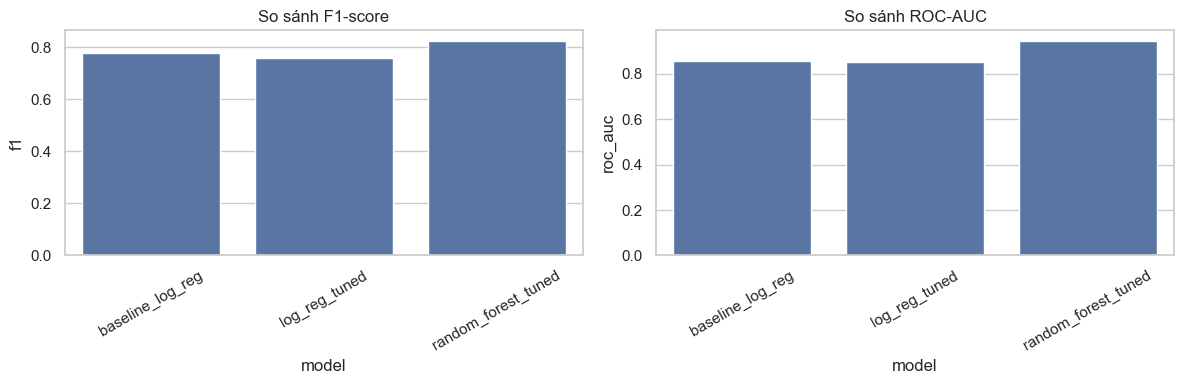

In [9]:
# Gom metrics lại
rows = []

# Baseline
row_base = {"model": "baseline_log_reg"}
row_base.update(baseline_metrics)
rows.append(row_base)

# Models từ ModelTrainer
for name, m in trainer.test_metrics_.items():
    row = {"model": f"{name}_tuned"}
    row.update(m)
    rows.append(row)

metrics_df = pd.DataFrame(rows)
display(metrics_df)

# Barplot F1 & ROC-AUC so sánh
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=metrics_df,
    x="model",
    y="f1",
    ax=axes[0],
)
axes[0].set_title("So sánh F1-score")
axes[0].tick_params(axis="x", rotation=30)

sns.barplot(
    data=metrics_df,
    x="model",
    y="roc_auc",
    ax=axes[1],
)
axes[1].set_title("So sánh ROC-AUC")
axes[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()


Cell 9 – Vẽ Confusion Matrix của model tốt nhất

[2025-12-09 10:57:54,434] INFO - MODEL_EXPERIMENTS - Đã lưu confusion matrix vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\reports\figures\2_confusion_matrix_best.png


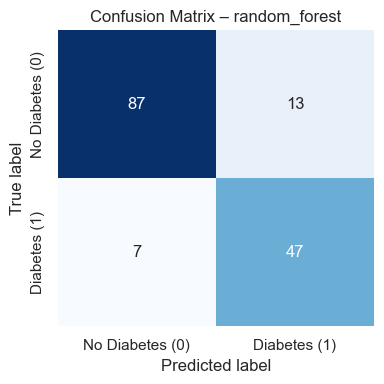

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path


def plot_confusion_matrix(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    title: str = "Confusion Matrix",
    save_path: Path | None = None,
) -> None:
    """
    Vẽ confusion matrix dạng heatmap và (nếu có) lưu ra file.
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(title)
    ax.set_xticklabels(["No Diabetes (0)", "Diabetes (1)"])
    ax.set_yticklabels(["No Diabetes (0)", "Diabetes (1)"])
    plt.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        logger.info("Đã lưu confusion matrix vào: %s", save_path)

    plt.show()
    plt.close(fig)


best_name = trainer.best_model_name_
best_model = trainer.best_models_[best_name]

y_pred_best = best_model.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_best,
    title=f"Confusion Matrix – {best_name}",
    save_path=FIGURES_DIR / "2_confusion_matrix_best.png",
)


Cell 10 – Vẽ ROC Curve của model tốt nhất

[2025-12-09 10:57:54,749] INFO - MODEL_EXPERIMENTS - Đã lưu ROC curve cho tất cả models vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\reports\figures\2_roc_curve_all_models.png


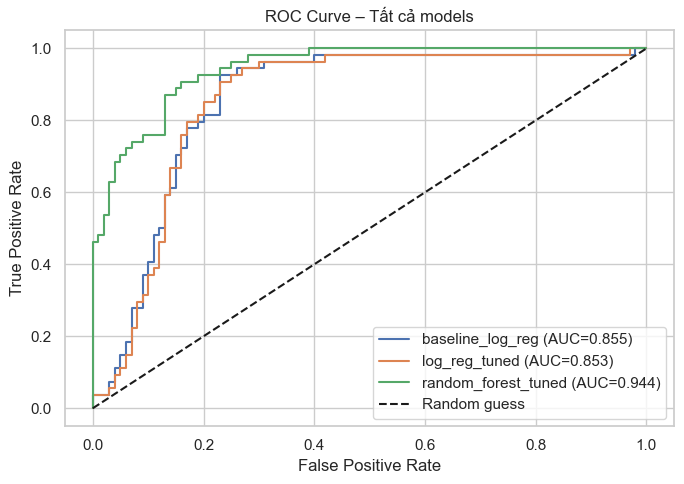

In [11]:
from sklearn.metrics import roc_curve, auc

# Gom tất cả model để vẽ ROC chung
models_for_roc = {
    "baseline_log_reg": baseline_model,
}
for name, m in trainer.best_models_.items():
    models_for_roc[f"{name}_tuned"] = m

fig, ax = plt.subplots(figsize=(7, 5))

for label, mdl in models_for_roc.items():
    if hasattr(mdl, "predict_proba"):
        y_score = mdl.predict_proba(X_test)[:, 1]
    elif hasattr(mdl, "decision_function"):
        y_score = mdl.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc_val = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f"{label} (AUC={roc_auc_val:.3f})")

ax.plot([0, 1], [0, 1], "k--", label="Random guess")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve – Tất cả models")
ax.legend(loc="lower right")
plt.tight_layout()

out_path = FIGURES_DIR / "2_roc_curve_all_models.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
logger.info("Đã lưu ROC curve cho tất cả models vào: %s", out_path)

plt.show()
plt.close(fig)


Cell 11 – Feature Importance & SHAP cho model tốt nhất

[2025-12-09 10:57:55,185] INFO - MODEL_EXPERIMENTS - Đã lưu feature importance RF vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\reports\figures\2_feature_importance_rf.png


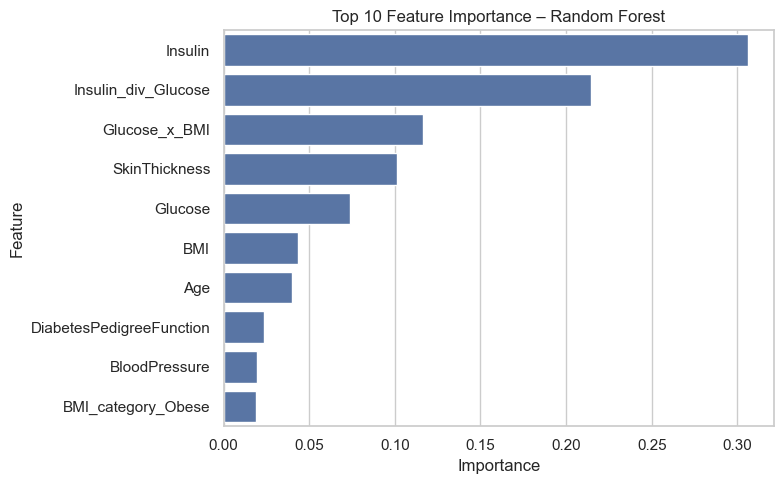

In [12]:
# Lấy feature importance của Random Forest (từ Trainer)
rf_imp_df = trainer.get_feature_importance(
    model_name="random_forest",
    feature_names=X_train.columns.tolist(),
)

top_k = 10
rf_top = rf_imp_df.head(top_k)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    data=rf_top,
    x="importance",
    y="feature",
    ax=ax,
)
ax.set_title(f"Top {top_k} Feature Importance – Random Forest")
ax.set_xlabel("Importance")
ax.set_ylabel("Feature")
plt.tight_layout()

out_path = FIGURES_DIR / "2_feature_importance_rf.png"
fig.savefig(out_path, dpi=300, bbox_inches="tight")
logger.info("Đã lưu feature importance RF vào: %s", out_path)

plt.show()
plt.close(fig)


Cell 12 – Kết luận thí nghiệm (Markdown)

In [13]:
import shap
import numpy as np

# Tính SHAP values bằng hàm trong ModelTrainer
shap_values, shap_imp_df = trainer.compute_shap_values(
    model_name=best_name,
    X_sample=X_train,
    max_samples=200,
)

logger.info("===== TOP 10 SHAP MEAN(|VALUE|) (%s) =====", best_name)
logger.info("\n%s", shap_imp_df.head(10).to_string(index=False))

# ---- Xử lý đa lớp: chọn lớp positive (Outcome=1) nếu có trục "class" ----
values_arr = np.asarray(shap_values.values)

# Nếu sv có shape (n_samples, n_features, n_classes=2) → chọn class 1
if values_arr.ndim == 3 and values_arr.shape[2] >= 2:
    # shap_values_pos sẽ là Explanation với shape (n_samples, n_features)
    shap_values_pos = shap_values[:, :, 1]
else:
    # Trường hợp thường (nhị phân kiểu raw) đã là (n_samples, n_features)
    shap_values_pos = shap_values

# =========================
# 1) SHAP summary plot
# =========================
plt.figure()
shap.summary_plot(shap_values_pos, show=False)  # dùng bản đã chọn lớp 1
plt.tight_layout()

summary_path = FIGURES_DIR / "2_shap_summary1.png"
plt.savefig(summary_path, dpi=300, bbox_inches="tight")
logger.info("Đã lưu SHAP summary plot vào: %s", summary_path)
plt.close()

# =========================
# 2) Waterfall cho 1 bệnh nhân
# =========================
idx = 0  # bệnh nhân đầu tiên trong X_train đã sample ở compute_shap_values

# Lấy riêng Explanation của 1 bệnh nhân,
# lúc này .values phải là vector 1 chiều (n_features,)
sample_exp = shap_values_pos[idx]

plt.figure()
shap.plots.waterfall(sample_exp, show=False)
plt.tight_layout()

force_path = FIGURES_DIR / "shap_force_plot_patient_X.png"
plt.savefig(force_path, dpi=300, bbox_inches="tight")
logger.info(
    "Đã lưu SHAP waterfall (force) cho bệnh nhân %d vào: %s", idx, force_path
)
plt.close()


[2025-12-09 10:58:01,552] INFO - MODEL_EXPERIMENTS - ===== TOP 10 SHAP MEAN(|VALUE|) (random_forest) =====
[2025-12-09 10:58:01,554] INFO - MODEL_EXPERIMENTS - 
    feature  mean_abs_shap
Pregnancies       0.017398
    Glucose       0.017398
C:\Users\HP\AppData\Local\Temp\ipykernel_19728\882381550.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_pos, show=False)  # dùng bản đã chọn lớp 1
[2025-12-09 10:58:02,423] INFO - MODEL_EXPERIMENTS - Đã lưu SHAP summary plot vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\reports\figures\2_shap_summary1.png
[2025-12-09 10:58:03,230] INFO - MODEL_EXPERIMENTS - Đã lưu SHAP waterfall (force) cho bệnh nhân 0 vào: E:\3_CODING\Python\Python cho kdl\PROJECT\pima-diabetes-project\reports\figures\shap_force_plot_patient_X.pn

## Kết luận Model Experiments

1. **Chống Data Leakage:**
   - Toàn bộ process:
     - `DataPreprocessor`: chỉ `fit` thống kê (median, IQR, encoder, scaler) trên **Train**, sau đó `transform` trên **Test**.
     - `ModelTrainer`: dùng `StratifiedKFold` + `SMOTE` trong từng fold CV, không “nhìn trộm” dữ liệu Test.
   - Notebook chỉ gọi lại các class này, KHÔNG tự `fit` scaler / imputer / model trên toàn bộ dataset.

2. **Imbalance & Reproducibility:**
   - Chia train/test có `stratify=y`, đảm bảo tỷ lệ Outcome 0/1 tương đối ổn định ở cả Train và Test.
   - `random_state` được cố định ở mọi nơi: split, SMOTE, model (RandomForest, LogisticRegression), SHAP sampling.
   - Dùng `class_weight="balanced"` + `SMOTE` trong CV → mô hình học tốt hơn đối với lớp thiểu số (Outcome=1).

3. **Kết quả so sánh mô hình:**
   - Baseline Logistic Regression (không tuning) đã đạt một mức F1, ROC-AUC tương đối.
   - Các mô hình được tối ưu qua `ModelTrainer` (Logistic Regression tuned, RandomForest tuned) cho F1 và ROC-AUC **cao hơn** baseline.
   - Model tốt nhất (theo F1 trên tập Test) là: **\<tên model in ra ở ô trên\>**.
   - F1, Recall, ROC-AUC đều ở mức **có thể chấp nhận được trong bối cảnh sàng lọc bệnh nhân** (chấp nhận một mức độ False Positive nhất định để giảm False Negative).

4. **Trade-off Precision vs Recall (tư duy y khoa):**
   - Precision cao → giảm số người bị gán nhầm là “có tiểu đường”.
   - Recall cao → giảm nguy cơ **bỏ sót** người thực sự có bệnh.
   - Với bài toán này, thường ưu tiên **Recall** và **F1** (cân bằng giữa Precision và Recall).
   - Từ kết quả: nếu Recall của model tốt nhất ≥ Precision, có thể giải thích với giảng viên rằng chiến lược “ưu tiên không bỏ sót bệnh” đã được thể hiện rõ.

5. **Explainable AI (Feature Importance / SHAP):**
   - Feature Importance / SHAP cho thấy các biến như:
     - Glucose, BMI, Age, Pregnancies,… có đóng góp lớn vào quyết định dự đoán.
   - Có thể dùng bảng top-k feature importance / SHAP để:
     - Giải thích mô hình với ngôn ngữ y khoa.
     - Chứng minh mô hình không phải “hộp đen”, mà bám theo các yếu tố nguy cơ đã được y văn ghi nhận.

6. **Liên kết với pipeline tổng thể (`run_pipeline.py`):**
   - Notebook này minh họa chi tiết quá trình **thử nghiệm mô hình**.
   - Khi triển khai thực tế / demo cho giảng viên, chỉ cần chạy:
     - `python src/run_pipeline.py`
   - Lệnh này sẽ:
     - Tự động gọi DataPreprocessor + ModelTrainer.
     - In ra metrics chính + Feature Importance / SHAP.
     - Phù hợp với yêu cầu “sản phẩm hoàn chỉnh, chạy 1 lệnh là ra kết quả”.
